In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch

# Automatic differentiation

In [2]:
x = torch.tensor(np.linspace(-2*np.pi, 2*np.pi, 100), dtype=torch.float32).reshape(100, 1)
x.requires_grad = True

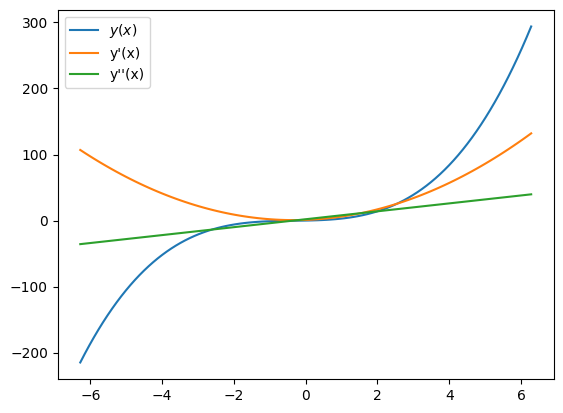

In [3]:
y = x * x * x + x * x + x
dydx = torch.autograd.grad(y, x, torch.ones_like(y), create_graph=True)[0]
d2ydx2 = torch.autograd.grad(dydx, x, torch.ones_like(dydx), create_graph=True)[0]

plt.plot(x.detach().numpy(), y.detach().numpy(), label='$y(x)$')
plt.plot(x.detach().numpy(), dydx.detach().numpy(), label="y'(x)")
plt.plot(x.detach().numpy(), d2ydx2.detach().numpy(), label="y''(x)")
plt.legend()
plt.show()

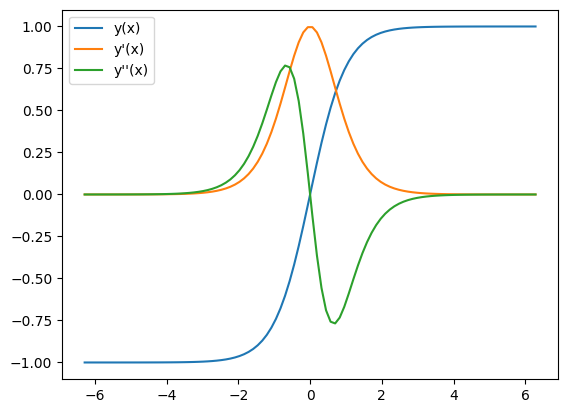

In [4]:
y = torch.tanh(x)
dydx = torch.autograd.grad(y, x, torch.ones_like(y), create_graph=True)[0]
d2ydx2 = torch.autograd.grad(dydx, x, torch.ones_like(dydx), create_graph=True)[0]

plt.plot(x.detach().numpy(), y.detach().numpy(), label='y(x)')
plt.plot(x.detach().numpy(), dydx.detach().numpy(), label="y'(x)")
plt.plot(x.detach().numpy(), d2ydx2.detach().numpy(), label="y''(x)")
plt.legend()
plt.show()

# Solving a system of differential equations

In [5]:
import torch.nn as nn
import torch.optim as optim

from IPython import display

In [6]:
class ODE(nn.Module):
    def __init__(self):
        super(ODE, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(1, 40),
            nn.GELU(),
            nn.Linear(40, 40),
            nn.GELU(),
            nn.Linear(40, 2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean = 0, std = 0.1)
                nn.init.constant_(m.bias, val = 0.0)
                
    def forward(self, x):
        return self.net(x)
    
class ODELoss(nn.Module):
    def __init__(self, ode):
        super(ODELoss, self).__init__()
        self.ode = ode
        
    def forward(self, x):
        
        funcs  = self.ode(x)
        
        c, s = map(lambda i:  funcs[:,[i]], range(2))
        dc = gradients(c, x)
        ds = gradients(s, x)
        
        zero_vals = self.ode(torch.zeros(1,1))
                
        eq_loss = torch.mean((dc + s)**2 + (ds - c)**2)
        ic_loss = (zero_vals[0,0] - 1)**2 + zero_vals[0,1]**2
        
        return eq_loss, ic_loss

NameError: name 'gradients' is not defined

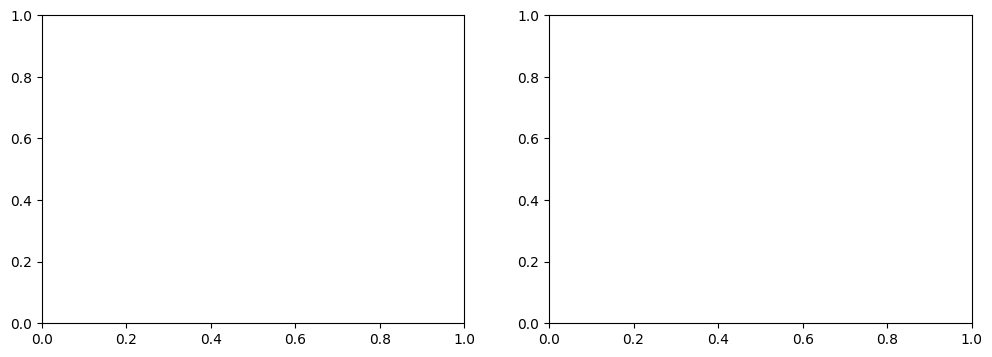

In [7]:
ode = ODE()
odeloss = ODELoss(ode)
loss_hist = []

optimizer = optim.Adam(ode.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=(0.1)**(1/5000))

x = torch.tensor(np.linspace(0, 10, 100, dtype = np.float32)).reshape(100, 1)
x.requires_grad = True

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 4));
font = {'size'   : 19}
plt.rc('font', **font)

for epoch in range(3000):
    try:
        optimizer.zero_grad()

        eq_loss, ic_loss = odeloss(x)
        loss = eq_loss + ic_loss
        loss.backward()
        optimizer.step()
        
        scheduler.step()
        loss_hist.append(loss.item())
        
        if epoch % 100 == 0:
            
            ax1.cla()
            ax1.set_xlabel('epoch')
            ax1.set_ylabel('loss')
            ax1.set_yscale('log')
            ax1.plot(loss_hist)

            ax2.cla()
            ax2.set_xlabel('x')
            ax2.set_ylabel('y')
            ax2.plot(x.cpu().detach().numpy(), ode(x)[:, 0].cpu().detach().numpy())
            ax2.plot(x.cpu().detach().numpy(), ode(x)[:, 1].cpu().detach().numpy())

            display.display(plt.gcf())
            display.clear_output(wait=True)
            plt.tight_layout()
            
    except KeyboardInterrupt:
        break